In [152]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import keras
import shutil
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, Dropout, Activation, Dense, Flatten, BatchNormalization
from keras.models import Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.preprocessing import image
from keras.metrics import categorical_crossentropy
from keras.layers.convolutional import *
from keras.applications import imagenet_utils
from keras.optimizers import adam
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

In [153]:
# import local files
import models

In [155]:
# Function to resize images
def resize(img, width, height, interpolation=cv2.INTER_AREA):
    return cv2.resize(img, (width, height), interpolation)

In [156]:
# Function to load images from folder
def images_from_folder(folder, label = 1):
    images = []
    labels = []
    for file in os.listdir(folder):
        image = cv2.imread(os.path.join(folder,file))
        if image is not None:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = resize(image, 224, 224)
            images.append(image)
            labels.append(label)
    return images, labels

In [157]:
# Loading images
covid_features, covid_labels = images_from_folder("/".join(os.getcwd().split("/")[:-1] + ["data","covid"]))
noncovid_features, noncovid_labels = images_from_folder("/".join(os.getcwd().split("/")[:-1] + ["data","non_covid"]), label = 0)

In [158]:
len(covid_labels)
len(noncovid_labels)

337

In [161]:
images = covid_features + noncovid_features
labels = covid_labels + noncovid_labels

In [162]:
len(images)

674

In [163]:
# Convert to Numpy arrays
data = np.asarray(images)
labels = np.asarray(labels)

In [164]:
# Image normalization
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    '''
    if v2:
        x = x - 0.5
        x = x * 2.0
    '''
    return x

In [165]:
data = preprocess_input(data)

In [166]:
labels = keras.utils.to_categorical(labels)

In [167]:
# To split data into traiing and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [168]:
# Data generator - To generate batches of tensor images with real-time data augmentation.
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [169]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [170]:
# Build Model
model = models.mobilenet(num_classes = 2)
print(len(model.layers))

89


In [171]:
# Freeze the 1st 75 layers
for layer in model.layers[:75]:
        layer.trainable = False

In [172]:
# Compiling model
model.compile(
    loss='categorical_crossentropy',  # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [173]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [174]:
# Re-train the last 14 layers of the model
history = model.fit_generator(data_generator.flow(trainX,trainY,24),
                        steps_per_epoch=len(trainX) / 24,
                        epochs = 8,
                        validation_data=(testX, testY),
                        validation_steps=len(testX) / 24,
                        verbose=1)

Epoch 1/8
23/22 [==============================] - 164s 7s/step - loss: 0.2313 - accuracy: 0.9499 - val_loss: 3.0999 - val_accuracy: 0.7778
Epoch 2/8
23/22 [==============================] - 152s 7s/step - loss: 0.0585 - accuracy: 0.9833 - val_loss: 0.5913 - val_accuracy: 0.9185
Epoch 3/8
23/22 [==============================] - 153s 7s/step - loss: 0.0266 - accuracy: 0.9889 - val_loss: 0.2880 - val_accuracy: 0.9704
Epoch 4/8
23/22 [==============================] - 154s 7s/step - loss: 0.0503 - accuracy: 0.9796 - val_loss: 0.1195 - val_accuracy: 0.9778
Epoch 5/8
23/22 [==============================] - 153s 7s/step - loss: 0.0206 - accuracy: 0.9963 - val_loss: 0.1136 - val_accuracy: 0.9778
Epoch 6/8
23/22 [==============================] - 156s 7s/step - loss: 0.0269 - accuracy: 0.9926 - val_loss: 0.0614 - val_accuracy: 0.9926
Epoch 7/8
23/22 [==============================] - 159s 7s/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1779 - val_accuracy: 0.9630
Epoch 8/8
23/22 [===

In [175]:
# Model Evaluation
train_score = model.evaluate(trainX, trainY, verbose=0)
print(model.metrics_names)
print(train_score)
test_score = model.evaluate(testX, testY,verbose=0)
print(test_score)

['loss', 'accuracy']
[0.18510217580370647, 0.9573283791542053]
[0.2015561384735284, 0.970370352268219]


In [176]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=24)

# For each of the images in the testing set we need to find the 
# index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=["covid", "noncovid"]))

[INFO] evaluating network...


In [177]:
# To get the confusion matrix
tn, fp, fn, tp = confusion_matrix(testY.argmax(axis=1), predIdxs).ravel()
(tn, fp, fn, tp)

(54, 0, 4, 77)

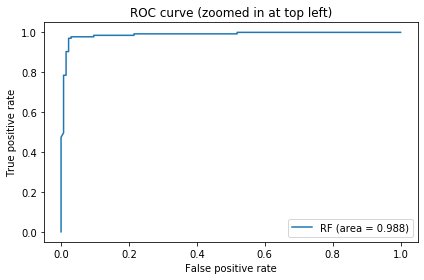

In [178]:
# To plot the Reciever Operating Curve (ROC)

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import auc

y_pred_keras = model.predict(testX).ravel()
testY = testY.flatten()

fpr_keras, tpr_keras,threshold = roc_curve(testY, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='RF (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('/Users/apoorvar/Desktop/Covid19Detection_gh/model/roc.tiff', dpi=200)
plt.show()

In [179]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

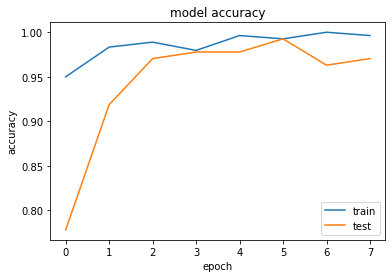

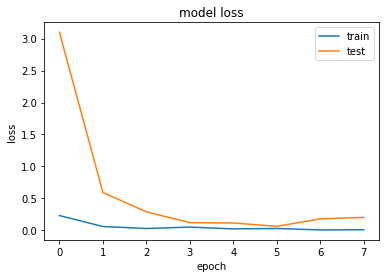

In [180]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig('/Users/apoorvar/Desktop/Covid19Detection_gh/model/acc.tiff', dpi=200)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig('/Users/apoorvar/Desktop/Covid19Detection_gh/model/loss.tiff', dpi=200)
plt.show()

In [181]:
# To save the trained model
model.save("/".join(os.getcwd().split("/")[:-1] + ["model/"])+"covidmodel.h5")

In [182]:
# To convert to TFLite version for use in a mobile application
model=tf.keras.models.load_model('/Users/apoorvar/Desktop/Covid19Detection_gh/model/covidmodel.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.experimental_new_converter = True
tflite_model = converter.convert()
open("converted_22_model.tflite", "wb").write(tflite_model)

12805140